## Import All Libraries

In [1]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [2]:
# Read data and EDA
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import numpy as np
import seaborn as sns
from wordcloud import WordCloud

# Preprocess
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from string import punctuation
from unidecode import unidecode

# Preparation and Evaluation
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

# Model Implementation
import tensorflow as tf
from tensorflow.keras.metrics import AUC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, Dense, Dropout, Embedding, SimpleRNN
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Load Data

In [3]:
train_essay = pd.read_csv("/kaggle/input/llm-detect-ai-generated-text/train_essays.csv", usecols=['text', 'generated'])
train_essay 

,text,generated
0,Cars. Cars have been around since they became ...,0
1,Transportation is a large necessity in most co...,0
2,"""America's love affair with it's vehicles seem...",0
3,How often do you ride in a car? Do you drive a...,0
4,Cars are a wonderful thing. They are perhaps o...,0
...,...,...
1373,There has been a fuss about the Elector Colleg...,0
1374,Limiting car usage has many advantages. Such a...,0
1375,There's a new trend that has been developing f...,0
1376,As we all know cars are a big part of our soci...,0


In [4]:
test_essay = pd.read_csv("/kaggle/input/llm-detect-ai-generated-text/test_essays.csv")
test_essay

,id,prompt_id,text
0,0000aaaa,2,Aaa bbb ccc.
1,1111bbbb,3,Bbb ccc ddd.
2,2222cccc,4,CCC ddd eee.


In [5]:
sample_sub = pd.read_csv("/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv")
sample_sub

,id,generated
0,0000aaaa,0.1
1,1111bbbb,0.9
2,2222cccc,0.4


## Exploratory Data Analysis (EDA)

In [6]:
train_essay.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1378 entries, 0 to 1377
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       1378 non-null   object
 1   generated  1378 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 21.7+ KB


In [7]:
def show_series_count(ser: pd.Series, ser_name: str):
    train_val_count = ser.value_counts().reset_index()
    plt.bar(train_val_count[train_val_count.columns[0]].astype(str), train_val_count['count'])
    plt.xlabel(ser_name)
    plt.title(f'{ser_name} label count')
    [plt.text(lbl, count, count, ha="center", va="bottom") for (lbl, count) in train_val_count.to_numpy()]
    plt.show()

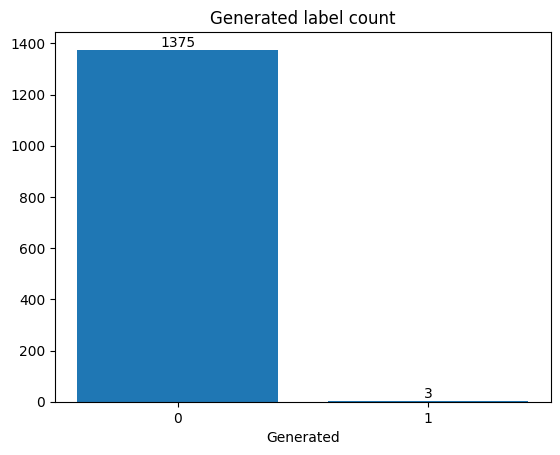

In [8]:
show_series_count(train_essay['generated'], 'Generated')

There is not enough test labels. We will need additional data to train the model.

In [9]:
extra_train_essay_1 = pd.read_csv("/kaggle/input/llm-generated-essays/ai_generated_train_essays.csv")
extra_train_essay_2 = pd.read_csv("/kaggle/input/llm-generated-essays/ai_generated_train_essays_gpt-4.csv")
train_essay = pd.concat([train_essay, extra_train_essay_1, extra_train_essay_2], ignore_index=True)

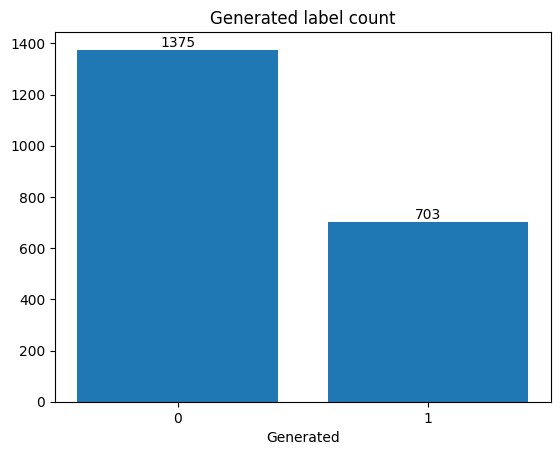

In [10]:
show_series_count(train_essay['generated'], 'Generated')

## Data Pre-processing

In [11]:
def clean_text(paragraphs):
    cleaned = []
    for word in paragraphs:
        lower_case = word.lower()
        if lower_case not in punctuation and lower_case not in stopwords.words('english') and len(word) > 2 and word.isalpha():
            cleaned.append(lower_case)
        else:
            continue
    return cleaned


def lemmatization(paragraphs):
    lemmatizer = WordNetLemmatizer()
    final_text = []
    for i in paragraphs:
        lemma_word = lemmatizer.lemmatize(i)
        final_text.append(lemma_word)
    return " ".join(final_text)


def text_preprocess(texts):
    replaced = texts.apply(lambda t: t.replace("\\n"," ").replace("\t"," "))
    decoded = replaced.apply(unidecode)
    tokenized = decoded.apply(word_tokenize)
    cleaned = tokenized.apply(clean_text)
    final_product = cleaned.apply(lemmatization)
    return final_product

In [12]:
train_text_processed = text_preprocess(train_essay['text'])

In [13]:
train_text_processed

0       car car around since became famous henry ford ...
1       transportation large necessity country worldwi...
2       america love affair vehicle seems cooling say ...
3       often ride car drive one motor vehicle work st...
4       car wonderful thing perhaps one world greatest...
                              ...                        
2073    dear senator senator name writing share opinio...
2074    dear senator writing today express opinion cur...
2075    dear senator hope letter find well writing exp...
2076    senator senator name constituent concerned stu...
2077    name address city state zip code email address...
Name: text, Length: 2078, dtype: object

In [14]:
train_essay_processed = pd.concat([train_text_processed, train_essay[['generated', 'prompt_id']]], axis=1)

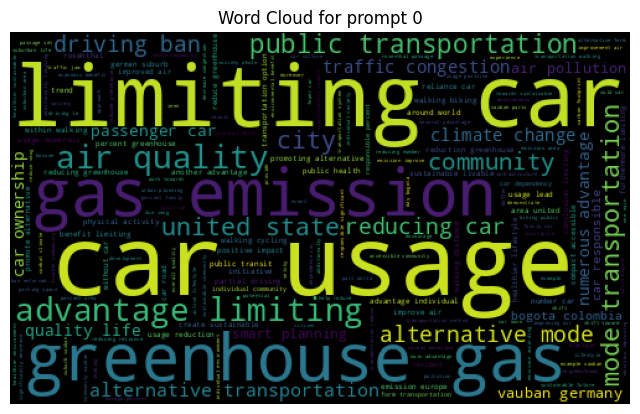

In [15]:
# Convert all articles into single string
word_cloud_0 = train_essay_processed.query('prompt_id == 0')['text'].str.cat(sep=" ")
word_cloud_0 = WordCloud(width=500, height=300).generate(word_cloud_0)
plt.figure(figsize=(8, 8))
plt.imshow(word_cloud_0)
plt.title('Word Cloud for prompt 0')
plt.axis("off")
plt.show()

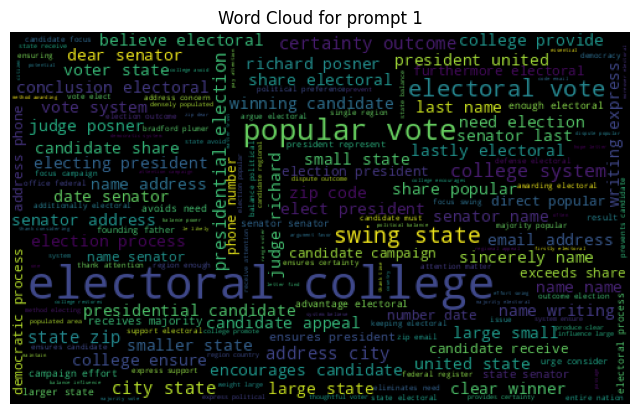

In [16]:
word_cloud_1 = train_essay_processed.query('prompt_id == 1')['text'].str.cat(sep=" ")
word_cloud_1 = WordCloud(width=500, height=300).generate(word_cloud_1)
plt.figure(figsize=(8, 8))
plt.imshow(word_cloud_1)
plt.title('Word Cloud for prompt 1')
plt.axis("off")
plt.show()

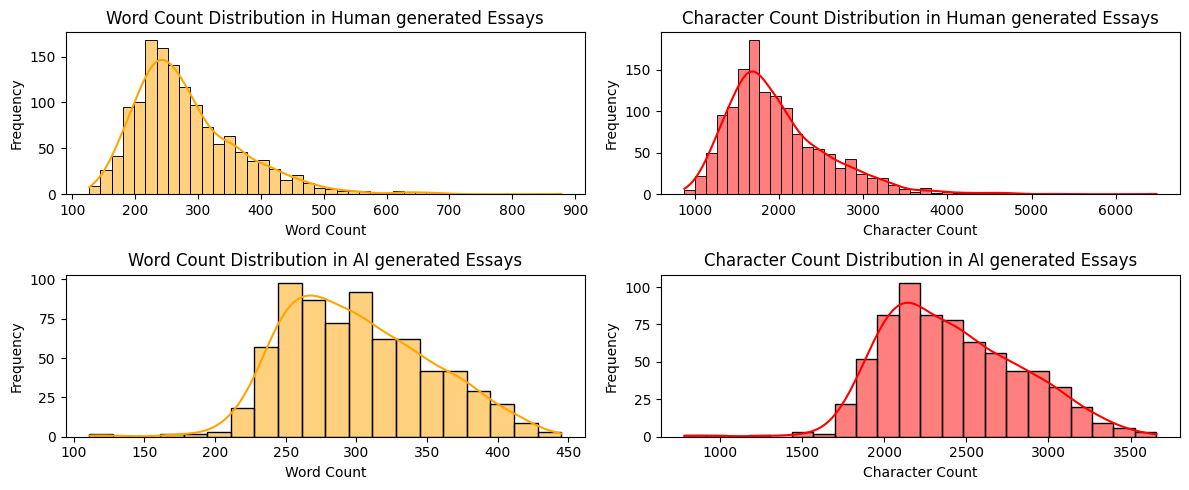

In [17]:
train_essay_processed['word_count'] = train_essay_processed['text'].apply(lambda x: len(x.split()))
train_essay_processed['char_count'] = train_essay_processed['text'].apply(len)

plt.figure(figsize=(12, 5))

plt.subplot(2, 2, 1)
sns.histplot(train_essay_processed.query('generated == 0')['word_count'], kde=True, color='orange')
plt.title('Word Count Distribution in Human generated Essays')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
sns.histplot(train_essay_processed.query('generated == 0')['char_count'], kde=True, color='red')
plt.title('Character Count Distribution in Human generated Essays')
plt.xlabel('Character Count')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
sns.histplot(train_essay_processed.query('generated == 1')['word_count'], kde=True, color='orange')
plt.title('Word Count Distribution in AI generated Essays')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

plt.subplot(2, 2, 4)
sns.histplot(train_essay_processed.query('generated == 1')['char_count'], kde=True, color='red')
plt.title('Character Count Distribution in AI generated Essays')
plt.xlabel('Character Count')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [18]:
word_occ_orig = Counter([word.lower() for words in train_essay_processed.query('prompt_id == 0')['text'] for word in words.split()])
df_temp_orig = pd.DataFrame(word_occ_orig.most_common(10))
df_temp_orig.columns = ['Common Words', 'count']

fig_common_words_orig = px.bar(df_temp_orig, x='count', y='Common Words', orientation='h', title='Top 10 Most Common Words for prompt 0')
fig_common_words_orig.show()

In [19]:
word_occ_orig = Counter([word.lower() for words in train_essay_processed.query('prompt_id == 1')['text'] for word in words.split()])
df_temp_orig = pd.DataFrame(word_occ_orig.most_common(10))
df_temp_orig.columns = ['Common Words', 'count']

fig_common_words_orig = px.bar(df_temp_orig, x='count', y='Common Words', orientation='h', title='Top 10 Most Common Words for prompt 1')
fig_common_words_orig.show()

## Data Split for train and test purpose for base model

In [20]:
x_train, x_val, y_train, y_val = train_test_split(train_text_processed, train_essay['generated'], test_size=0.2, shuffle=True)

In [21]:
print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(1662,)
(416,)
(1662,)
(416,)


In [22]:
all_train_words = []
for s in x_train:
    all_train_words.extend(s.split())
    
all_train_words = np.unique(all_train_words)

In [23]:
len(all_train_words)

14095

## Word Embedding

In [24]:
# max_words = int(np.ceil(len(all_train_words) / 100) * 100)
max_words = 15000
print(max_words)
x_train_np = x_train.values
x_val_np = x_val.values
tk = Tokenizer(num_words=max_words, oov_token="oov")
tk.fit_on_texts(x_train_np)

x_train_seq = tk.texts_to_sequences(x_train_np)
x_val_seq = tk.texts_to_sequences(x_val_np)

15000


In [25]:
len(x_train_seq)

1662

In [26]:
print("Max length of text:", max([len(seq) for seq in x_train_seq]))
print("Min length of text:", min([len(seq) for seq in x_train_seq]))

Max length of text: 878
Min length of text: 111


In [27]:
# max_len = max([len(seq) for seq in x_train_seq])
max_len = 900
x_train_padded = pad_sequences(x_train_seq, maxlen=max_len, padding="post", truncating="post")
x_val_padded = pad_sequences(x_val_seq, maxlen=max_len, padding="post", truncating="post")

In [28]:
print(x_train_padded.shape)
print(x_val_padded.shape)

(1662, 900)
(416, 900)


In [29]:
y_train_np = y_train.values
y_val_np = y_val.values

## RNN

In [30]:
model = Sequential()
model.add(Embedding(input_dim=max_words , output_dim=500 , input_length=max_len))
model.add(Bidirectional(SimpleRNN(100)))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy", AUC()])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 900, 500)          7500000   
                                                                 
 bidirectional (Bidirection  (None, 200)               120200    
 al)                                                             
                                                                 
 dense (Dense)               (None, 100)               20100     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                        

In [31]:
history = model.fit(x_train_padded, y_train_np, epochs=5, batch_size=64, validation_data=(x_val_padded, y_val_np))

Epoch 1/5
26/26 [==============================] - 50s 2s/step - loss: 0.2994 - accuracy: 0.8616 - auc: 0.9453 - val_loss: 0.0715 - val_accuracy: 0.9856 - val_auc: 0.9938
Epoch 2/5
26/26 [==============================] - 41s 2s/step - loss: 0.0175 - accuracy: 0.9940 - auc: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9952 - val_auc: 0.9959
Epoch 3/5
26/26 [==============================] - 41s 2s/step - loss: 5.3872e-04 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.0413 - val_accuracy: 0.9928 - val_auc: 0.9961
Epoch 4/5
26/26 [==============================] - 40s 2s/step - loss: 2.0333e-04 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.0446 - val_accuracy: 0.9928 - val_auc: 0.9961
Epoch 5/5
26/26 [==============================] - 40s 2s/step - loss: 1.3709e-04 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.0451 - val_accuracy: 0.9928 - val_auc: 0.9961


In [32]:
loss, acc, auc = model.evaluate(x_val_padded, y_val_np)

13/13 [==============================] - 2s 121ms/step - loss: 0.0451 - accuracy: 0.9928 - auc: 0.9961


In [33]:
print("Loss on validation data is:", loss)
print("Accuracy on validation data:", acc)
print("AUC on validation data:", auc)

Loss on validation data is: 0.04508190602064133
Accuracy on validation data: 0.9927884340286255
AUC on validation data: 0.9961000084877014


## Test Data Preprocessing and Prediction

In [34]:
test_text_processed = text_preprocess(test_essay['text'])
x_test_seq = tk.texts_to_sequences(test_text_processed.values)
x_test_padded = pad_sequences(x_test_seq, maxlen=max_len, padding="post", truncating="post")

In [35]:
x_test_padded.shape

(3, 900)

## Predictions on Test Data

In [36]:
y_pred = model.predict(x_test_padded)
y_pred

1/1 [==============================] - 0s 402ms/step


array([[3.586753e-07],
       [3.586753e-07],
       [3.586753e-07]], dtype=float32)

In [37]:
# ChatGPT 3.5 Generated paragraphs on prompt ID 0
gpt_text = 'In our rapidly evolving world, the convenience of personal automobiles has become deeply ingrained in our daily lives. However, it is essential to consider the broader implications of our reliance on cars, not just for individual comfort but also for the collective well-being of our society and the environment. This essay explores the advantages of limiting car usage, drawing insights from multiple sources to underscore the importance of embracing alternative transportation methods for a sustainable future.'
gpt_text_2 = 'One significant advantage of reducing car usage lies in the realm of environmental preservation. According to a report by the Environmental Protection Agency (EPA), the transportation sector is a major contributor to air pollution and greenhouse gas emissions. Cars emit pollutants that degrade air quality, leading to respiratory problems and other health issues. By limiting car usage and promoting alternatives such as public transportation, cycling, and walking, we can collectively reduce our carbon footprint and mitigate the impact of climate change.'
gpt_text_3 = 'Furthermore, limiting car usage can have profound positive effects on traffic congestion and urban planning. A study conducted by the Urban Land Institute reveals that the overreliance on cars contributes to congested roadways, leading to increased travel times and economic inefficiencies. Implementing measures to limit car usage, such as developing comprehensive public transportation systems and promoting carpooling, can alleviate traffic congestion, making cities more livable and efficient.'

# BBC news articles
bbc_text = 'Those alleged conversations were outlined in an indictment unsealed by US prosecutors on Wednesday. The US Justice Department has charged Mr Gupta with an elaborate plot to assassinate a dual US-Canadian citizen based in New York, a plot allegedly directed by an Indian government employee.'
bbc_text_1 = 'In the Paris Agreement itself, the baseline for pre-industrial measures wasn\'t defined. But the International Panel on Climate Change uses a baseline of 1850-1900. That\'s because it\'s the earliest period with reliable, near-global measurements. It\'s true that some warming from human activity had already occurred by that point, because the industrial revolution began in the early 1700s. But having good historical data for a reliable baseline is crucial to measure changes happening today.'
bbc_text_2 = 'The room bustled with the din of volunteer waitstaff and diners amid a jazzy soundtrack playing overhead. A knife suddenly clanged against the floor. No one seemed to hear it except for renowned, three-Michelin starred chef Massimo Bottura, who instinctively ran over to pick it up, gave the diner a new utensil and initiated a warm, friendly chat to ensure he was enjoying his meal. With Bottura, the patrons at this church hall are given the same level of hospitality as those at his high-end restaurants like the famed Osteria Francescana and the newly opened Al Gatto Verde in Modena, Italy.'

extra_texts = [gpt_text, gpt_text_2, gpt_text_3, bbc_text, bbc_text_1, bbc_text_2]
extra_texts = pd.DataFrame({'text': extra_texts, 'generated': [1, 1, 1, 0, 0, 0]})
extra_text_seq = tk.texts_to_sequences(extra_texts['text'])
extra_text_padded = pad_sequences(extra_text_seq , maxlen=max_len ,padding="post",truncating="post")
model.evaluate(extra_text_padded, extra_texts['generated'])

1/1 [==============================] - 1s 849ms/step - loss: 1.5419 - accuracy: 0.6667 - auc: 0.8333


[1.541943907737732, 0.6666666865348816, 0.8333333730697632]

In [38]:
model.save_weights('detect_ai_generated')

In [39]:
model.load_weights('detect_ai_generated')

In [40]:
model.evaluate(extra_text_padded, extra_texts['generated'].values)

1/1 [==============================] - 0s 154ms/step - loss: 1.5420 - accuracy: 0.6667 - auc: 0.8333


[1.541953682899475, 0.6666666865348816, 0.8333333730697632]

In [41]:
# Assuming 'test_ids' are the IDs of test samples, and 'predictions' are the predicted values
# submission = pd.DataFrame({'id': test_essay['id'] , 'generated': output })
# submission.to_csv('submission.csv', index=False)  # Save the CSV file

In [42]:
# d = pd.read_csv("submission.csv")
# d